In [1]:
import torch

import pyro
import pyro.distributions as dist

In [2]:
x = pyro.sample('my sample', dist.Normal(0, 1))

In [3]:
x

tensor(0.4795)

In [4]:
for i in range(10):
    x = pyro.sample('sample %i' % i, dist.Normal(0, 1))
    print(x)

tensor(1.8168)
tensor(-0.1986)
tensor(-0.5247)
tensor(2.0272)
tensor(1.00000e-02 *
       4.3414)
tensor(0.2663)
tensor(1.00000e-02 *
       8.6536)
tensor(1.6285)
tensor(-1.6850)
tensor(2.0426)


In [5]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    
    return cloudy, temp.item()

In [6]:
for _ in range(10):
    print(weather())

('cloudy', 61.00165939331055)
('cloudy', 44.299224853515625)
('sunny', 53.686744689941406)
('sunny', 70.01533508300781)
('sunny', 53.175479888916016)
('sunny', 80.22586822509766)
('sunny', 89.3553237915039)
('sunny', 64.74252319335938)
('sunny', 73.01749420166016)
('sunny', 76.43522644042969)


In [7]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', dist.Normal(expected_sales, 10.0))
    
    return ice_cream

In [8]:
for _ in range(10):
    print(ice_cream_sales())

tensor(66.1401)
tensor(33.9498)
tensor(55.5411)
tensor(47.8335)
tensor(217.7011)
tensor(31.8184)
tensor(40.2561)
tensor(53.9382)
tensor(32.7089)
tensor(45.4772)


In [9]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), dist.Bernoulli(p))
    if x.item() == 0:
        return x
    else:
        return x + geometric(p, t + 1)

In [10]:
for _ in range(10):
    print(geometric(0.5))

tensor(1.)
tensor(4.)
tensor(1.)
tensor(5.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)


In [11]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    y = z1 * z2
    
    return y


def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    
    return fn


In [12]:
for _ in range(10):
    print(make_normal_normal()(1.))

tensor(0.2787)
tensor(1.00000e-02 *
       3.7896)
tensor(0.5879)
tensor(-0.5863)
tensor(1.1063)
tensor(0.9568)
tensor(-1.5843)
tensor(2.9480)
tensor(2.6418)
tensor(1.00000e-02 *
       -1.3294)


## Marginal Distributions

In [13]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [14]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [15]:
guess = 8.5

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))

In [16]:
print(marginal())

tensor(8.2525)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0,0.5,'#')

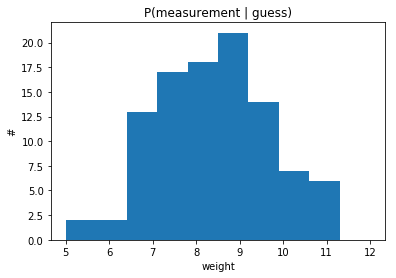

In [18]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

## Conditioning Models on Data

In [19]:
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

In [20]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={'measurement': measurement})(*args, **kwargs)

In [21]:
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0.0, 1.0)))
    
    return pyro.sample("measurement", dist.Normal(weight, tolerance))


In [22]:

# best not to use hardcoding as seen in `scale()`
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0.0, 1.0)))
    
    return pyro.sample("measurement", dist.Normal(weight, tolerance))


In [23]:
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}),
    data={"measurement": 9.5}
)

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.5}),
    data={"measurement": 9.2}
)

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5}
)

In [24]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(
    scale,
    data={'measurement': measurement}
)


# what is `sites` a flag for?
marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight"
)


tensor(8.5339)


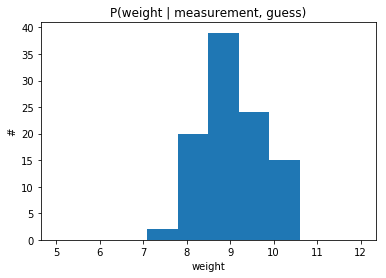

In [25]:
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

### Guide Functions

Functions that use arbitary _stochastic functions_ to use as __approximate posterior distributions__.

Guide fucntions must meet two criteria:
1. All unobserved sample statements that appear in the model appear in the guide.
2. The guide has the same input signature as the model _(takes the same arguments)_

_from the docs:_

    Guide functions can serve as programmable, data-dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, only importance sampling and stochastic variational inference are implemented in Pyro, but we plan to add other algorithms in the future.

In [26]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(
    conditioned_scale,
    guide=scale_prior_guide,
    num_samples=10,
)

marginal = pyro.infer.EmpiricalMarginal(
    posterior.run(guess),
    sites="weight",
)

In [27]:
def scale_posterior_guide(measurement, guess):
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.)
    b = 1. / (measurement.size(0) + 1.0)
    
    return pyro.sample("weight", dist.Normal(a, b))

In [28]:
posterior = pyro.infer.Importance(
    deferred_conditioned_scale,
    guide=scale_posterior_guide,
    num_samples=20,
)

Text(0,0.5,'#')

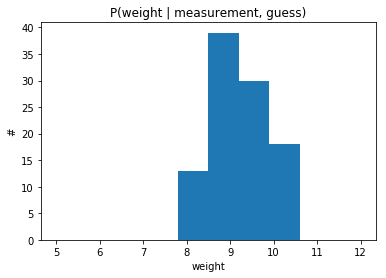

In [29]:
marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [30]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))

In [31]:
def scale_parameterized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

## Stochastic Variational Inference

_(From The Docs)_
Pyro is built to enable __stochastic variational inference__, a powerful and widely applicable class of variational inference algorithms with three key characteristics:

1. Parameters are always real-valued tensors
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide
3. We use stochastic gradient descent to search for the optimal parameters.

In [32]:
pyro.clear_param_store()

In [33]:
# svi = pyro.infer.SVI(
#     model=conditioned_scale,
#     guide=scale_parameterized_guide,
#     optim=pyro.optim.optim.SGD({"lr": 0.001}),
#     loss=pyro.infer.Trace_ELBO()
# )

# losses = []
# for t in range(1000):
#     losses.append(svi.step(guess))

# plt.plot(losses)
# plt.title("ELBO")
# plt.xlabel("step")
# plt.ylabel("loss")

In [35]:
del marginal

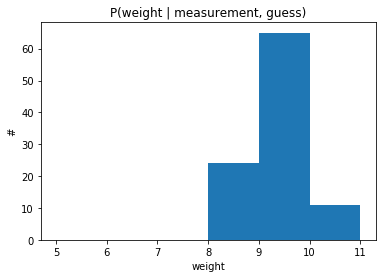

In [42]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parameterized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight", )

plt.hist([marginal().item() for _ in range(100)], range(5, 12))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Approximate Posterior

Sampled directly from the guide.

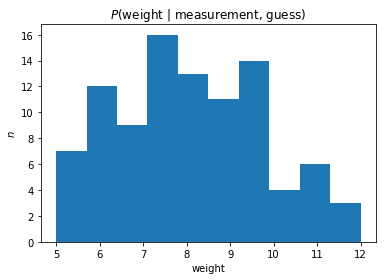

In [48]:
plt.hist([scale_parameterized_guide(guess).item() for _ in range(100)], range=(5., 12.))
plt.title("$P$(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("$n$");

# Stochastic Variational Inference (SVI)

In [49]:
model

NameError: name 'model' is not defined